Import Libraries

In [1]:
import utils
from CTClayer import CTCLayer
from SquareRootScheduler import SquareRootScheduler
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
print('tf version: ', tf.__version__)

tf version:  2.7.0


Set the parameters

In [2]:
#number of epochs
epochs = 200
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4


early_stopping_patience = 10

A function to create model

In [5]:
"""
This function creates our OCR model for reading captchas
"""
def build_model():
    """
    :return model
    """    
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the GRU part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # GRUs
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(utils.char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model"
    )
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=3e-4)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


Create dataset objects

In [4]:
train_dataset,validation_dataset=utils.getData(batch_size)

Training model

Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']          

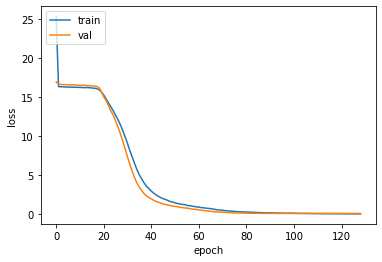

In [6]:
# Get the model
model = build_model()
model.summary()
plot_model(model,show_shapes=True)
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

#Learning Rate Scheduler
scheduler = SquareRootScheduler(lr=3e-4)
lrate = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,lrate]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()